In [13]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import math

import qf.cc
import qf.graphs
import qf.morph
import qf.qastar
import qf.qzss
import qf.zssexp
import qf.util

Let us first introduce a function that rewires a given percentage of arcs (keeping the same nodes and number of arcs)

In [14]:
def rewire(G, alpha=0.5):
    """
    Given a MultiDiGraph G, and a parameter alpha between 0 and 1, return a new graph
    with the same nodes and with the same number of arcs; each arc, with probability alpha,
    is rewired (i.e., its source and target are changed, both chosen randomly). All arcs
    possess a distinct "label".
    """
    NG = nx.MultiDiGraph()
    NG.add_nodes_from(list(G.nodes()))
    for u, v in G.edges():
        label = qf.morph.new_arc_label(NG)
        if random.random()<alpha:
            source = random.choice(list(G.nodes()))
            target = random.choice(list(G.nodes()))
            qf.graphs.add_edges_with_name(NG, [(source, target, label)])
        else:
            qf.graphs.add_edges_with_name(NG, [(u, v, label)])
    return NG

In [15]:
def excDef(G, gt):
    """
    Given a MultiDiGraph G (its arcs need to possess distinct "labels", that are otherwise immaterial) 
    and an equivalence relation on its nodes (represented as a dictionary with nodes as keys and equivalence-class-values)
    return excess and deficiency of the qf map.
    """
    B, f = qf.morph.qf_build(G, gt)
    gte, gtd = qf.morph.excess_deficiency(f, G, B) 
    return (gte, gtd)

In [16]:
def perturbateEquivPCS(gt):
    """
    Given an equivalence relation (represented as a dictionary), returns another equivalence with the same 
    set of keys and the same multiset of values. (PCS stands for "Preserve Class Size")
    """
    ks=list(gt.keys())
    vs=[gt[k] for k in gt.keys()]
    random.shuffle(ks)
    return {k: v for (k,v) in zip(ks, vs)}

def perturbateEquivPCN(gt):
    """
    Given an equivalence relation (represented as a dictionary), returns another equivalence with the same 
    set of keys and the same number of values. (PCN stands for "Preserve Class Number")
    """
    ks = list(gt.keys())
    vset = list(set(gt.values()))
    vs = list(vset)
    toAdd = len(ks) - len(vs)
    for  i in range(toAdd):
        vs.append(random.choice(vset))
    return {ks[i]: vs[i] for i in range(len(ks))}

In [17]:
def computeED(G, gt, perturbateFunc=perturbateEquivPCS, samples=100):
    res=[]
    for i in range(samples):
        eq = perturbateFunc(gt)
        res.append(excDef(G, eq))
    return res

In [18]:
def exper(G, gt, samples=10):
    """
    Given a MultiDiGraph Gideal with a fibration symmetry described by gt, do a number of experiments (described 
    as follows). Each experiment produces some XY points, has a label and a colour. The result of the call is
    a list with the results of all experiments, each result being a dictionary with keys:
        - 'points': the list of points (each point being a 2-tuple containing X and Y)
        - 'label': the label of the experiment
        - 'color': the color to be used to name the experiment.
    Each experiment consists in computing excess (X) and deficiency (Y) in reconstructing a fibration symmetry
    of some graph with respect to a given equivalence relation.
    The experiments performed have label:
        - 'No pert.': the graph G and the original equivalence relation gt are used
        - 'PCN': the graph G and an equivalence relation with the same class sizes as gt are used (samples times)
        - 'PCS': the graph G and an equivalence relation with the same number of classes as gt are used (samples times)
    """
    d=[
        {'points': computeED(G, gt, perturbateFunc=perturbateEquivPCN, samples=samples), 'color': 'blue', 'label': 'PCN'},
        {'points': computeED(G, gt, perturbateFunc=perturbateEquivPCS, samples=samples), 'color': 'green', 'label': 'PCS'},
        {'points': computeED(G, gt, perturbateFunc=lambda x: x, samples=1), 'color': 'red', 'label': 'No pert.'},
    ]
    return d

Original graph: n=30, nodes=30, arcs=68
Minimum base: nodes=10, arcs=65
Result: nodes=31, arcs=210


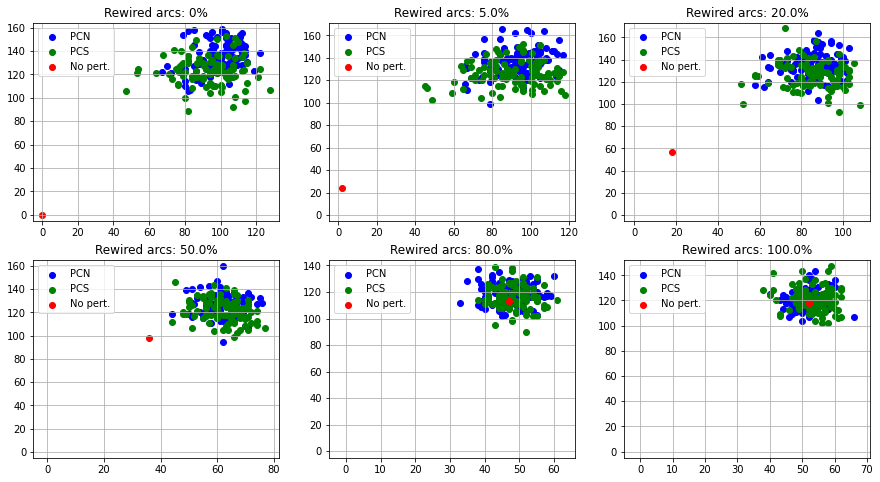

In [25]:
Gideal = qf.zssexp.get_fibration_rich_graph(30)
gt = qf.cc.cardon_crochemore(Gideal)

alphas=[0, 0.05, 0.2, 0.5, 0.8, 1.0]

fig, axsarray = plt.subplots(math.ceil(len(alphas) / 3), 3, squeeze=False, figsize=(15,8))
axs = axsarray.flatten()

for i in range(len(alphas)):
    G = rewire(Gideal, alpha=alphas[i])
    d = exper(G, gt, samples=100)
    xs_all = []
    ys_all = []
    for t in d:
        xs = [s[0] for s in t['points']]
        ys = [s[1] for s in t['points']]
        axs[i].scatter(xs, ys, color=t['color'], label=t['label'])
        xs_all.extend(xs)
        ys_all.extend(ys)
    axs[i].legend(loc='upper left')
    axs[i].grid(True)
    axs[i].set_title("Rewired arcs: {}%".format(100 * alphas[i]))
    axs[i].set_xlim([-5, max(xs_all)+5])
    axs[i].set_ylim([-5, max(ys_all)+5])
    
plt.show()

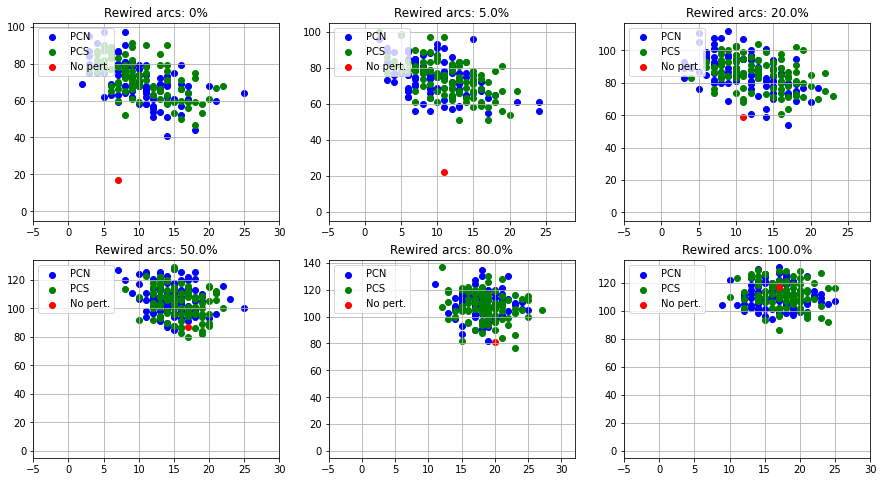

In [26]:
Gideal = qf.util.read_graph("../../Datasets/Shortcuts/backward-graph.tsv", coordinates=qf.util.read_coordinates("../../Datasets/Shortcuts/backward-coordinates.txt"))
gt = qf.util.read_label("../../Datasets/Shortcuts/backward-ground-truth.tsv")

alphas=[0, 0.05, 0.2, 0.5, 0.8, 1.0]

fig, axsarray = plt.subplots(math.ceil(len(alphas) / 3), 3, squeeze=False, figsize=(15,8))
axs = axsarray.flatten()

for i in range(len(alphas)):
    G = rewire(Gideal, alpha=alphas[i])
    d = exper(G, gt, samples=100)
    xs_all = []
    ys_all = []
    for t in d:
        xs = [s[0] for s in t['points']]
        ys = [s[1] for s in t['points']]
        axs[i].scatter(xs, ys, color=t['color'], label=t['label'])
        xs_all.extend(xs)
        ys_all.extend(ys)
    axs[i].legend(loc='upper left')
    axs[i].grid(True)
    axs[i].set_title("Rewired arcs: {}%".format(100 * alphas[i]))
    axs[i].set_xlim([-5, max(xs_all)+5])
    axs[i].set_ylim([-5, max(ys_all)+5])
    
plt.show()

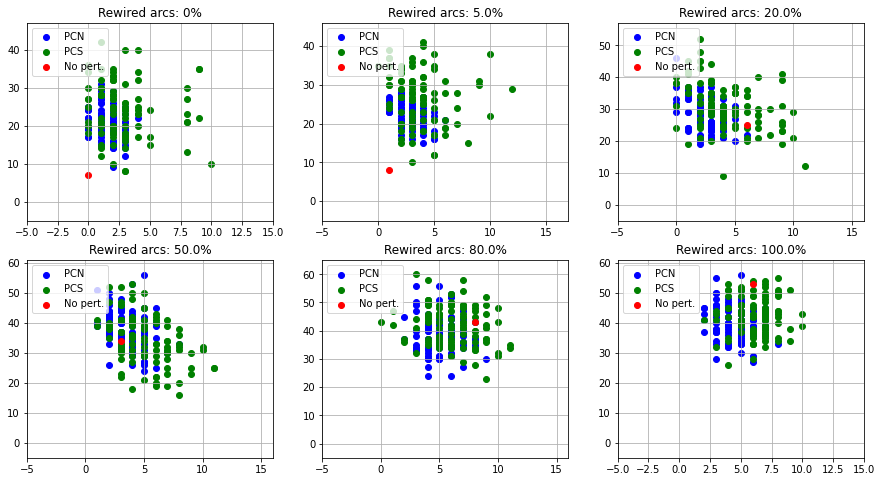

In [27]:
Gideal = qf.util.read_graph("../../Datasets/Shortcuts/forward-graph.tsv", coordinates=qf.util.read_coordinates("../../Datasets/Shortcuts/forward-coordinates.txt"))
gt = qf.util.read_label("../../Datasets/Shortcuts/forward-ground-truth.tsv")

alphas=[0, 0.05, 0.2, 0.5, 0.8, 1.0]

fig, axsarray = plt.subplots(math.ceil(len(alphas) / 3), 3, squeeze=False, figsize=(15,8))
axs = axsarray.flatten()

for i in range(len(alphas)):
    G = rewire(Gideal, alpha=alphas[i])
    d = exper(G, gt, samples=100)
    xs_all = []
    ys_all = []
    for t in d:
        xs = [s[0] for s in t['points']]
        ys = [s[1] for s in t['points']]
        axs[i].scatter(xs, ys, color=t['color'], label=t['label'])
        xs_all.extend(xs)
        ys_all.extend(ys)
    axs[i].legend(loc='upper left')
    axs[i].grid(True)
    axs[i].set_title("Rewired arcs: {}%".format(100 * alphas[i]))
    axs[i].set_xlim([-5, max(xs_all)+5])
    axs[i].set_ylim([-5, max(ys_all)+5])
    
plt.show()

Let us visualize the graph G:

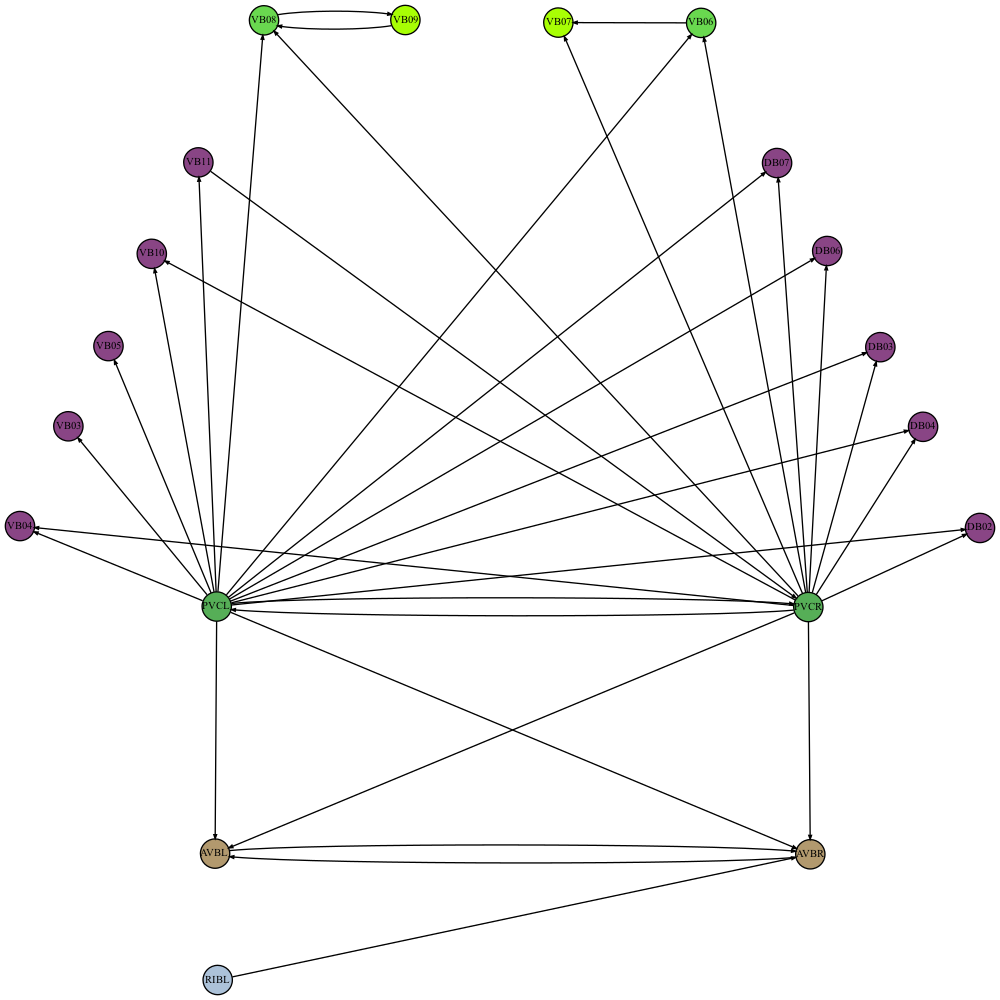

In [23]:
qf.graphs.visualize(Gideal, gt)

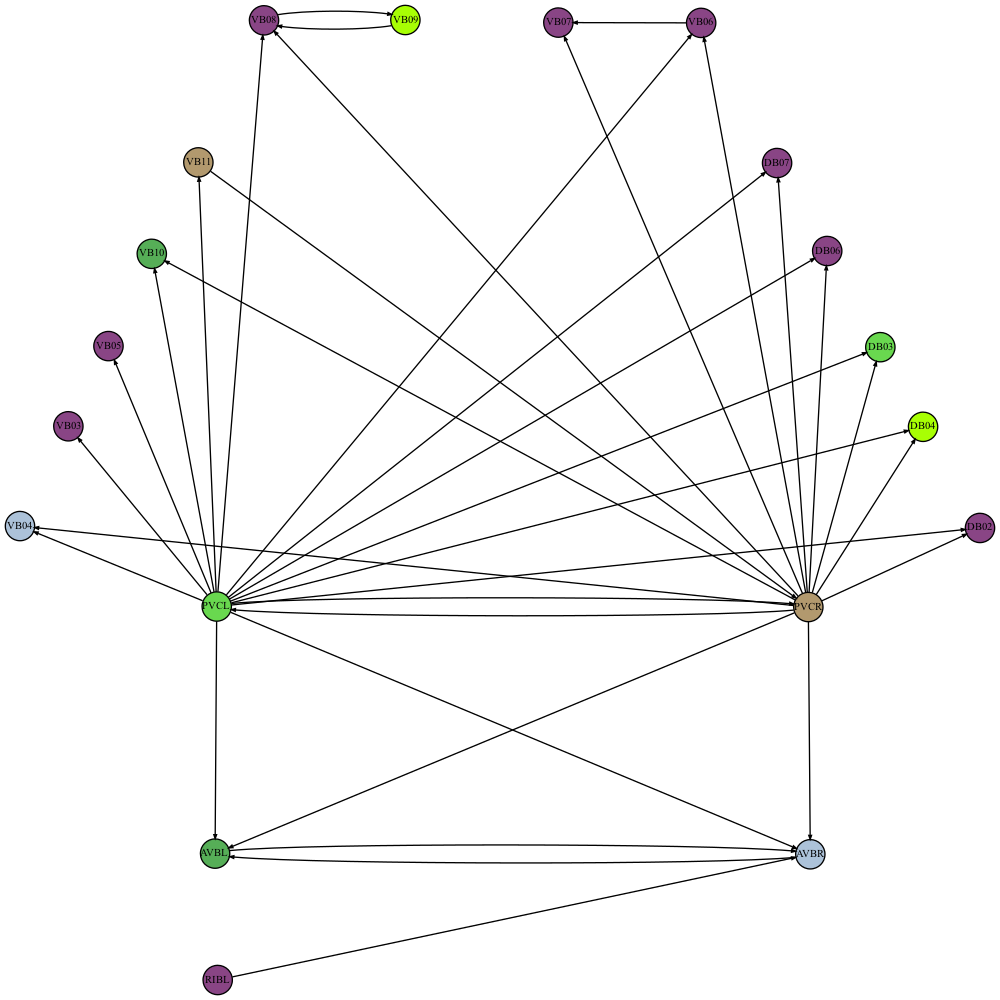

In [24]:
qf.graphs.visualize(Gideal, perturbateEquivPCS(gt))